In [7]:
import numpy
from custom_gates import RiSwapGate
import weylchamber
from qiskit import QuantumCircuit
from itertools import cycle
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter
import numpy as np

In [8]:
class TemplateCircuit:
    def __init__(
        self,
        n_qubits=2,
        base_gate_class=[RiSwapGate],
        gate_2q_params=[1 / 2],
        edge_params=[(0, 1)],
        trotter=False,
        trotter_variant=False
    ):
        """Initalizes a qiskit.quantumCircuit object with unbound 1Q gate parameters
        Args:
            n_qubits: size of target unitary,
            base_gate_class: Gate class of 2Q gate,
            gate_2q_params: List of params to define template gate cycle sequence
            edge_params: List of edges to define topology cycle sequence
            trotter: if true, only use gate_2q_params[0], override cycle length and edge_params, each 1Q gate share parameters per qubit row
        """
        self.hash = (
            str(n_qubits)
            + str(base_gate_class)
            + str(gate_2q_params)
            + str(edge_params)
            + str(trotter)
        )

        if n_qubits != 2 and trotter:
            raise NotImplementedError
        self.n_qubits = n_qubits
        self.trotter = trotter
        self.circuit = QuantumCircuit(n_qubits)
        self.gate_2q_base = base_gate_class

        self.cycles = 0

        if self.trotter:
            if self.gate_2q_base != [RiSwapGate]:
                raise NotImplementedError
            
            self.gate_2q_base = cycle(base_gate_class)
            # fixed param value, take first element
            self.gate_2q_params = cycle(gate_2q_params[:1])
            # override edges
            self.gate_2q_edges = cycle([(0, 1)])
            # fixed length, equals a full gate
            self.cycle_length = 1
        else:
            self.gate_2q_base = cycle(base_gate_class)
            self.gate_2q_params = cycle(gate_2q_params)
            self.gate_2q_edges = cycle(edge_params)
            self.cycle_length = max(len(gate_2q_params), len(edge_params))

        self.gen_1q_params = self._param_iter()

    # def __str__(self):
    #     s = ""
    #     for param in self.gate_2q_params:
    #         s += self.gate_2q_base.latex_string(param)
    #     return s

    def build(self, n_repetitions):
        self._reset()
        if self.trotter:
            #n_repetitions = int(1 / next(self.gate_2q_params))
            pass
        for _ in range(n_repetitions - 1):
            self._build_cycle()

    def _reset(self):
        """Return template to a single cycle"""
        self.cycles = 0
        self.circuit = QuantumCircuit(self.n_qubits)
        self._build_cycle(initial=True)

    def initial_guess(self):
        """returns a np array of random values for each parameter"""
        return np.random.random(len(self.circuit.parameters)) * 2 * np.pi

    def assign_Xk(self, Xk):
        
        return self.circuit.assign_parameters(
                {parameter: i for parameter, i in zip(self.circuit.parameters, Xk)}
            )
    def eval(self, Xk):
        """returns an Operator after binding parameter array to template"""
        return Operator(self.assign_Xk(Xk)).data

    def _param_iter(self):
        index = 0
        while True:
            # Check if Parameter already created, then return reference to that variable
            def _filter_param(param):
                return param.name == f"P{index}"

            res = list(filter(_filter_param, self.circuit.parameters))
            if len(res) == 0:
                yield Parameter(f"P{index}")
            else:
                yield res[0]
            index += 1
            if self.trotter:
                index %= 3 * self.n_qubits

    def _build_cycle(self, initial=False):
        """Extends tempalte by one full cycle"""
        if initial:
            # before build by extend, add first pair of 1Qs
            for qubit in range(self.n_qubits):
                self.circuit.u(*[next(self.gen_1q_params) for _ in range(3)], qubit)
        for _ in range(self.cycle_length):
            edge = next(self.gate_2q_edges)
            self.circuit.append(next(self.gate_2q_base)(next(self.gate_2q_params)), edge)
            for qubit in edge:
                self.circuit.u(*[next(self.gen_1q_params) for _ in range(3)], qubit)
        self.cycles += 1


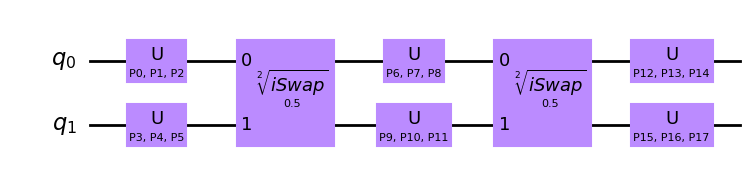

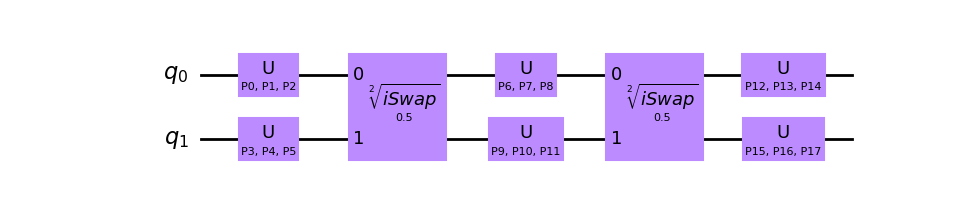

In [9]:
qc = TemplateCircuit(gate_2q_params=[1/2])
qc.build(2)
qc.circuit.draw(output='mpl')

In [10]:
def sample(param=1/2, length=2, N=4000):
    #want to characterize the vectors from 2,2, template
    list_coordinates = []
    for _ in range(N):
        qc = TemplateCircuit(gate_2q_params=[param])
        qc.build(length)
        Xk = qc.initial_guess()
        qc = qc.assign_Xk(Xk)
        gate = Operator(qc).data
        c1, c2, c3 = weylchamber.c1c2c3(gate)
        w.add_point(c1, c2, c3)
        list_coordinates.append((c1,c2,c3))
    
    return list_coordinates

In [11]:
import ipympl
%matplotlib widget

volume inside points is:  0.020527139624513985


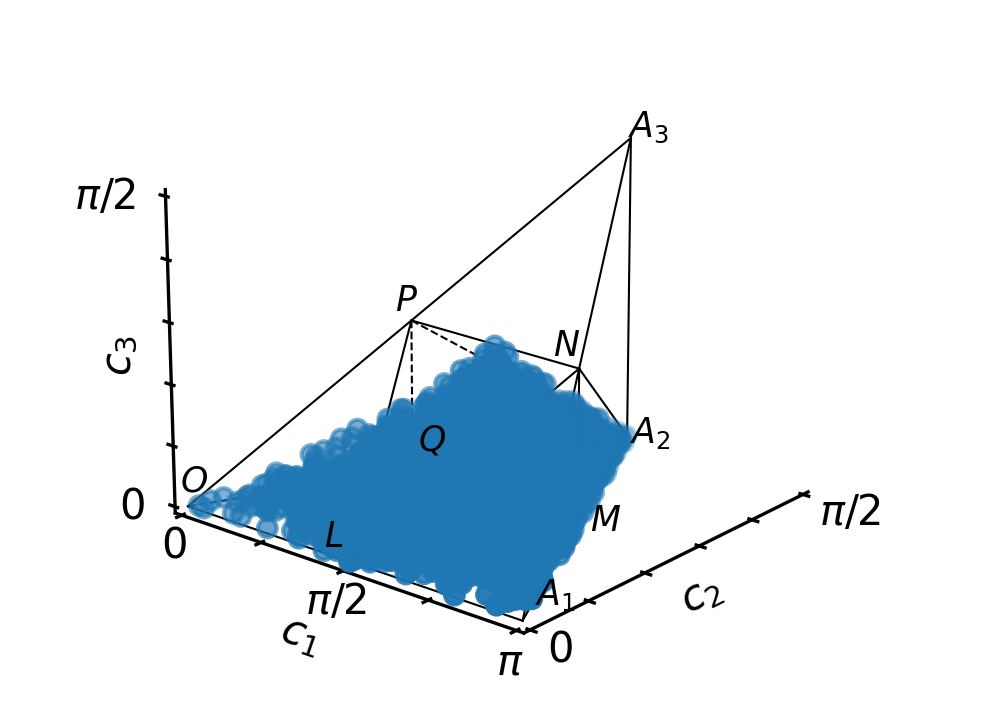

In [12]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/2, length=2)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)

volume inside points is:  0.014897507379858085


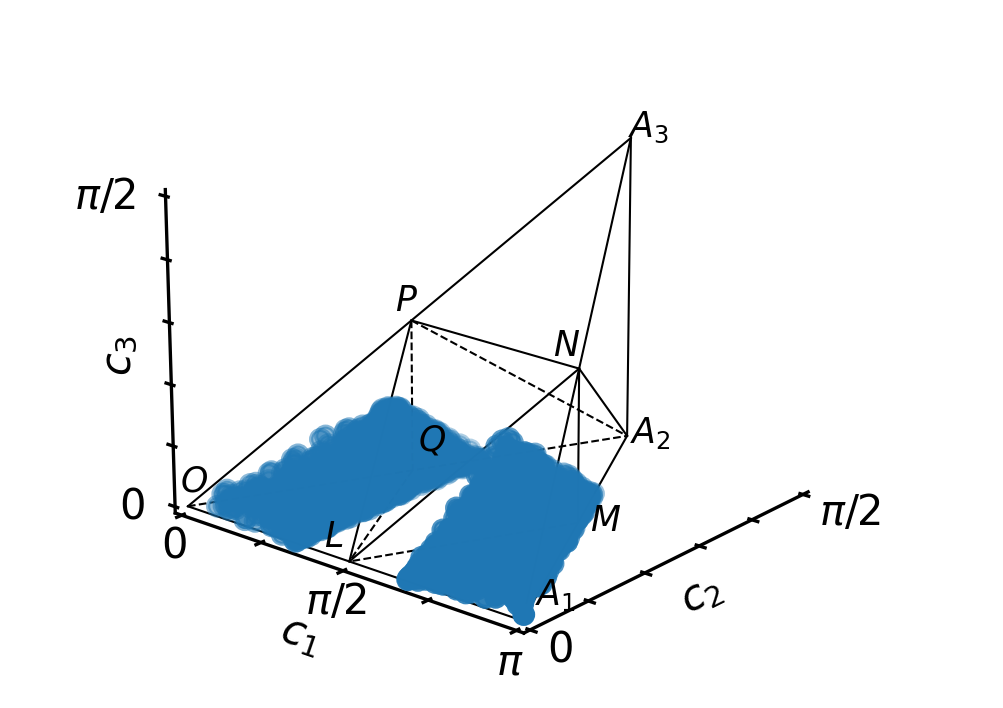

In [13]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/3, length=2)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)

volume inside points is:  0.025464319117115095


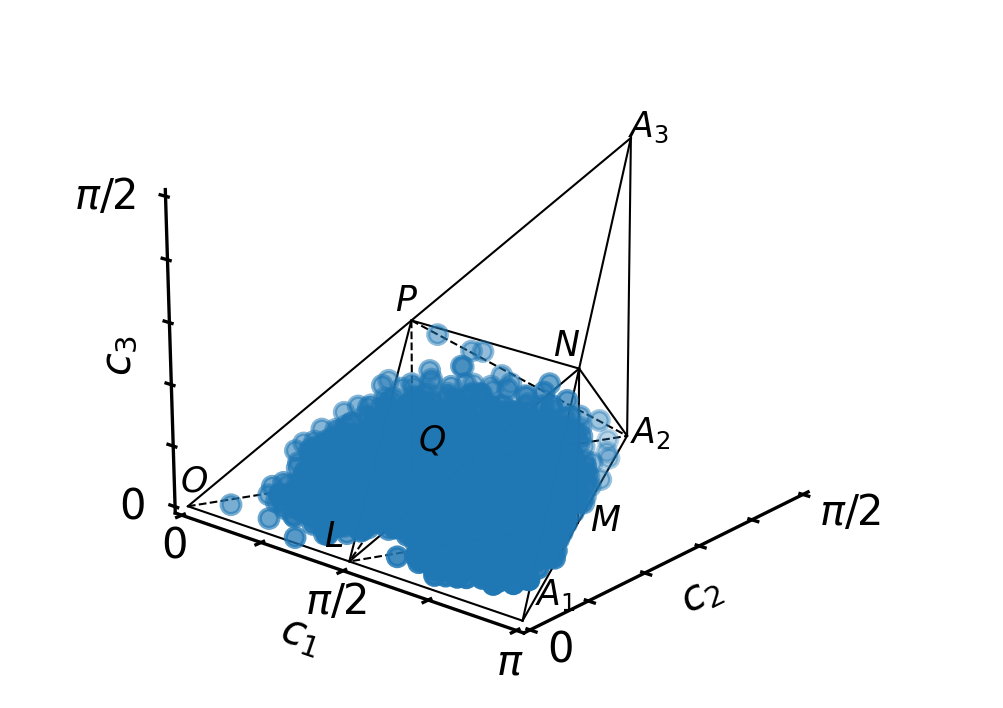

In [14]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/3, length=3)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)